In [1]:
import h5py
import numpy as np
import keras
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import gc
import pickle
from sklearn import model_selection
from sklearn import preprocessing

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input, concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [3]:
def loadDataH5():
    with h5py.File('C:\Technical\MSc\Semester2\Mandatory\Deep Learning\Assignment2\earth_data\earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

In [4]:
trainX, trainY, valX, valY = loadDataH5()

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


In [5]:
no_of_classes = len(np.unique(trainY))

In [6]:
def plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    
    plt.title("model loss/accuracy")
    plt.xlabel("epochs")
    plt.ylabel("loss/accuracy")
    plt.legend(['train loss', 'val loss', 'train acc', 'val acc'], loc = "upper right")
    plt.show()

# VGG16

## Monitoring val_loss

In [6]:
trainX = keras.applications.vgg16.preprocess_input(trainX)
valX = keras.applications.vgg16.preprocess_input(valX)

vgg16Model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
vgg16Model.trainable = True
trainableFlag = False

for layer in vgg16Model.layers:
    if layer.name == 'block4_conv1':
        trainableFlag = True
    layer.trainable = trainableFlag

vgg16Model.summary()

model = Sequential()
model.add(vgg16Model)
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(no_of_classes, activation="softmax"))

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [7]:
opt = RMSprop(learning_rate=0.00001)
model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics=['accuracy'])
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [8]:
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, callbacks=es)

Epoch 1/100
600/600 [==============================] - 40s 66ms/step - loss: 0.6514 - accuracy: 0.8267 - val_loss: 0.2591 - val_accuracy: 0.9181
Epoch 2/100
600/600 [==============================] - 40s 66ms/step - loss: 0.1501 - accuracy: 0.9507 - val_loss: 0.2356 - val_accuracy: 0.9285
Epoch 3/100
600/600 [==============================] - 40s 66ms/step - loss: 0.0777 - accuracy: 0.9746 - val_loss: 0.1894 - val_accuracy: 0.9433
Epoch 4/100
600/600 [==============================] - 40s 66ms/step - loss: 0.0418 - accuracy: 0.9862 - val_loss: 0.1822 - val_accuracy: 0.9567
Epoch 5/100
600/600 [==============================] - 40s 66ms/step - loss: 0.0218 - accuracy: 0.9930 - val_loss: 0.2470 - val_accuracy: 0.9479
Epoch 6/100
600/600 [==============================] - 40s 66ms/step - loss: 0.0134 - accuracy: 0.9956 - val_loss: 0.2451 - val_accuracy: 0.9508
Epoch 7/100
600/600 [==============================] - 40s 66ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.2539 - val_ac

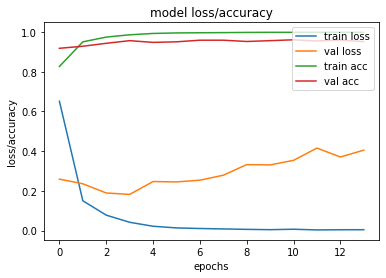

In [13]:
plot(history)

In [14]:
train_preds = model.predict_classes(trainX)
val_preds = model.predict_classes(valX)

print("Performance on Train data")
print(confusion_matrix(trainY, train_preds))
print("accuracy: ", accuracy_score(trainY, train_preds))

print("Performance on val data")
print(confusion_matrix(valY, val_preds))
print("accuracy: ", accuracy_score(valY, val_preds))


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Performance on Train data
[[2393    0    0    1    0    4    2    0    0]
 [   0 2393    6    0    0    1    0    0    0]
 [   0    1 2392    1    0    3    1    2    0]
 [   0    0    0 1996    2    0    0    0    2]
 [   0    0    0    0 1998    0    0    2    0]
 [   0    1    4    1    0 1594    0    0    0]
 [   0    0    7    0    0    0 1993    0    0]
 [   0    0    0    0    1    0    0 2399    0]
 [   1    0    0    2    0    0    0    0 1997]]
accuracy:  0.99765625
Performance on val data
[[572   1   2   4   0  10   8   1   2]
 [  0 587   8   1   0   4   0   0   0]
 [  2   6 570   1   0   7   7   7   0]
 [  5   0   0 475   0   1   4   2  13]
 [  2

## Monitoring val_accuracy instead of val_loss

In [7]:
trainX = keras.applications.vgg16.preprocess_input(trainX)
valX = keras.applications.vgg16.preprocess_input(valX)

vgg16Model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
vgg16Model.trainable = True
trainableFlag = False

for layer in vgg16Model.layers:
    if layer.name == 'block4_conv1':
        trainableFlag = True
    layer.trainable = trainableFlag

vgg16Model.summary()

model = Sequential()
model.add(vgg16Model)
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(no_of_classes, activation="softmax"))

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [9]:
opt = RMSprop(learning_rate=0.00001)
model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics=['accuracy'])
es = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

In [10]:
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, callbacks=es)

Epoch 1/100
600/600 [==============================] - 39s 66ms/step - loss: 0.6516 - accuracy: 0.8238 - val_loss: 0.2277 - val_accuracy: 0.9296
Epoch 2/100
600/600 [==============================] - 39s 66ms/step - loss: 0.1588 - accuracy: 0.9494 - val_loss: 0.1906 - val_accuracy: 0.9413
Epoch 3/100
600/600 [==============================] - 39s 66ms/step - loss: 0.0816 - accuracy: 0.9728 - val_loss: 0.1674 - val_accuracy: 0.9510
Epoch 4/100
600/600 [==============================] - 39s 66ms/step - loss: 0.0425 - accuracy: 0.9860 - val_loss: 0.2456 - val_accuracy: 0.9400
Epoch 5/100
600/600 [==============================] - 39s 66ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.2125 - val_accuracy: 0.9527
Epoch 6/100
600/600 [==============================] - 39s 66ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.2679 - val_accuracy: 0.9508
Epoch 7/100
600/600 [==============================] - 40s 66ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 0.2240 - val_ac

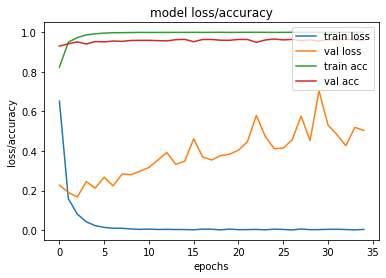

In [11]:
plot(history)

In [12]:
train_preds = model.predict_classes(trainX)
val_preds = model.predict_classes(valX)

print("Performance on Train data")
print(confusion_matrix(trainY, train_preds))
print("accuracy: ", accuracy_score(trainY, train_preds))

print("Performance on val data")
print(confusion_matrix(valY, val_preds))
print("accuracy: ", accuracy_score(valY, val_preds))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Performance on Train data
[[2400    0    0    0    0    0    0    0    0]
 [   0 2400    0    0    0    0    0    0    0]
 [   0    0 2400    0    0    0    0    0    0]
 [   0    0    0 2000    0    0    0    0    0]
 [   0    0    0    0 1999    0    1    0    0]
 [   0    0    0    0    0 1600    0    0    0]
 [   0    0    0    0    0    0 2000    0    0]
 [   0    0    0    0    1    0    0 2399    0]
 [   0    0    0    0    0    0    0    0 2000]]
accuracy:  0.9998958333333333
Performance on val data
[[579   1   0   4   0   3   9   0   4]
 [  0 588   9   1   0   2   0   0   0]
 [  1   1 584   1   0   6   7   0   0]
 [  6   0   0 476   2   0   5   1  1

# Resnet50

In [18]:
trainX = keras.applications.resnet50.preprocess_input(trainX)
valX = keras.applications.resnet50.preprocess_input(valX)

resnet50Model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
resnet50Model.trainable = True
trainableFlag = False

for layer in resnet50Model.layers:
    if layer.name == 'conv5_block3_1_conv':
        trainableFlag = True
    layer.trainable = trainableFlag

resnet50Model.summary()

model = Sequential()
model.add(resnet50Model)
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(no_of_classes, activation="softmax"))

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 2313      
Total params: 25,687,433
Trainable params: 6,565,385
Non-trainable params: 19,122,048
_________________________________________________________________


In [19]:
opt = RMSprop(learning_rate=0.00001)
model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics=['accuracy'])
es = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

In [20]:
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, callbacks=es)

Epoch 1/100
600/600 [==============================] - 24s 40ms/step - loss: 0.9458 - accuracy: 0.6744 - val_loss: 0.6599 - val_accuracy: 0.7750
Epoch 2/100
600/600 [==============================] - 23s 39ms/step - loss: 0.5763 - accuracy: 0.7992 - val_loss: 0.5555 - val_accuracy: 0.8135
Epoch 3/100
600/600 [==============================] - 23s 39ms/step - loss: 0.4675 - accuracy: 0.8372 - val_loss: 0.5329 - val_accuracy: 0.8150
Epoch 4/100
600/600 [==============================] - 23s 39ms/step - loss: 0.3923 - accuracy: 0.8621 - val_loss: 0.4917 - val_accuracy: 0.8354
Epoch 5/100
600/600 [==============================] - 23s 39ms/step - loss: 0.3349 - accuracy: 0.8834 - val_loss: 0.4858 - val_accuracy: 0.8392
Epoch 6/100
600/600 [==============================] - 23s 39ms/step - loss: 0.2891 - accuracy: 0.9011 - val_loss: 0.4832 - val_accuracy: 0.8438
Epoch 7/100
600/600 [==============================] - 23s 39ms/step - loss: 0.2537 - accuracy: 0.9157 - val_loss: 0.4766 - val_ac

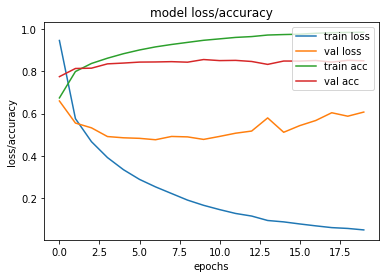

In [21]:
plot(history)

In [22]:
train_preds = model.predict_classes(trainX)
val_preds = model.predict_classes(valX)

print("Performance on Train data")
print(confusion_matrix(trainY, train_preds))
print("accuracy: ", accuracy_score(trainY, train_preds))

print("Performance on val data")
print(confusion_matrix(valY, val_preds))
print("accuracy: ", accuracy_score(valY, val_preds))


Performance on Train data
[[2354    2    3    1    0   26    1    0   13]
 [   0 2304   15    0    0   62    0    0   19]
 [   2    5 2337    6    0   30    5    6    9]
 [   5    0    5 1957    1    7    4    0   21]
 [   0    0    0    1 1997    0    1    1    0]
 [   5   10   34    4    0 1527    3    0   17]
 [   4    0   52   11    1   13 1913    1    5]
 [   0    0    4    0    1    0    1 2393    1]
 [   4    8    3   17    0    7    1    0 1960]]
accuracy:  0.9761458333333334
Performance on val data
[[541   1   2  14   1  14  12   0  15]
 [  0 570   9   1   0  17   0   0   3]
 [  2   3 509  22   6  11  27   7  13]
 [ 19   0  12 382   6   3  23   2  53]
 [  1   0   3  14 469   0   7   5   1]
 [  7   0  12   9   0 354   3   0  15]
 [ 28   1  59  52   6   9 331   1  13]
 [  0   0   8   3  15   0   0 574   0]
 [ 20   3  10  64   3  17   4   1 378]]
accuracy:  0.8558333333333333


In [10]:
trainX = keras.applications.resnet50.preprocess_input(trainX)
valX = keras.applications.resnet50.preprocess_input(valX)

resnet50Model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
resnet50Model.trainable = True
trainableFlag = False

for layer in resnet50Model.layers:
    if layer.name == 'conv5_block3_1_conv':
        trainableFlag = True
    layer.trainable = trainableFlag

resnet50Model.summary()

model = Sequential()
model.add(resnet50Model)
model.add(Flatten())
model.add(Dense(4096, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(4096, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation = "relu"))
model.add(Dense(no_of_classes, activation="softmax"))

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [14]:
opt = RMSprop(learning_rate=0.00001)
model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics=['accuracy'])
es = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

In [15]:
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, callbacks=es)

Epoch 1/100
600/600 [==============================] - 52s 87ms/step - loss: 0.6379 - accuracy: 0.7947 - val_loss: 0.3436 - val_accuracy: 0.8935
Epoch 2/100
600/600 [==============================] - 51s 85ms/step - loss: 0.3079 - accuracy: 0.8968 - val_loss: 0.2922 - val_accuracy: 0.9117
Epoch 3/100
600/600 [==============================] - 51s 85ms/step - loss: 0.2236 - accuracy: 0.9257 - val_loss: 0.2800 - val_accuracy: 0.9190
Epoch 4/100
600/600 [==============================] - 51s 85ms/step - loss: 0.1743 - accuracy: 0.9421 - val_loss: 0.2842 - val_accuracy: 0.9206
Epoch 5/100
600/600 [==============================] - 51s 85ms/step - loss: 0.1361 - accuracy: 0.9543 - val_loss: 0.2943 - val_accuracy: 0.9229
Epoch 6/100
600/600 [==============================] - 51s 85ms/step - loss: 0.1029 - accuracy: 0.9651 - val_loss: 0.2873 - val_accuracy: 0.9290
Epoch 7/100
600/600 [==============================] - 51s 85ms/step - loss: 0.0811 - accuracy: 0.9742 - val_loss: 0.2976 - val_ac

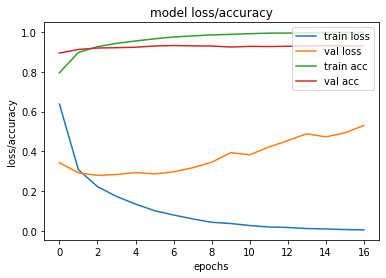

In [16]:
plot(history)

In [17]:
train_preds = model.predict_classes(trainX)
val_preds = model.predict_classes(valX)

print("Performance on Train data")
print(confusion_matrix(trainY, train_preds))
print("accuracy: ", accuracy_score(trainY, train_preds))

print("Performance on val data")
print(confusion_matrix(valY, val_preds))
print("accuracy: ", accuracy_score(valY, val_preds))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Performance on Train data
[[2391    2    0    0    0    4    3    0    0]
 [   0 2389    3    0    0    7    0    0    1]
 [   0   17 2363    2    1    6    6    5    0]
 [   0    0    2 1984    1    1    4    4    4]
 [   0    0    0    0 1997    0    0    3    0]
 [   2   17    8    3    0 1567    0    0    3]
 [   1    0    9    0    1    1 1986    2    0]
 [   0    0    0    0    0    0    0 2400    0]
 [   4    2    1    6    0    1    0    0 1986]]
accuracy:  0.9928645833333334
Performance on val data
[[572   2   1   3   0   3   9   0  10]
 [  0 588   4   0   0   7   0   1   0]
 [  1  11 553   4   0   6  13   7   5]
 [  6   0   3 433   4   6  11   5  3